In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.profiler import profile, record_function, ProfilerActivity
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import json
import seaborn as sns
import time
import itertools
import cProfile

## Data Preparation & Preprocessing

In [8]:
# Plot functions
def plot_last_prices(last_prices):
    plt.figure(figsize=(10, 5))
    plt.plot(last_prices, label='Normalized Prices')
    plt.legend()
    plt.ylabel('Normalized Price')
    plt.xlabel('Time Index')
    plt.title('Relative Change Rates of Close Prices')
    plt.show()

def plot_volume(data, title):
    plt.figure(figsize=(10, 5))
    plt.plot(data['datetime'], data['volume'])
    plt.xlabel('Date')
    plt.ylabel('Trade Volume')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

def plot_prices_with_ma(data, title):
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data['last_price'], label='Last Price')
    plt.plot(data.index, data['ma'], label='Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Last Price')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_prices_with_macd(data, title):
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data['macd_line'], label='MACD Line')
    plt.plot(data.index, data['signal_line'], label='MACD Signal Line')
    plt.plot(data.index, data['macd_histogram'], label='MACD Histogram Line')
    plt.xlabel('Date')
    plt.ylabel('Convergence/Divergence')
    plt.title(title)
    plt.legend()
    plt.show()

In [9]:
def load_configs(filename):
    with open(f'configs/{filename}.json', 'r') as file:
        return json.load(file)

In [10]:
# Moving Average (MA)
def moving_average(last_prices, num_periods):
    ma = last_prices.rolling(window=num_periods, min_periods=1).mean()
    # Forward fill the first num_periods-1 NaN values with the first non-NaN value
    ma.ffill(inplace=True)
    return ma

def calculate_ema(data, period):
    alpha = 2 / (period + 1)
    ema = [data.iloc[0]]  # EMA starts with the first data point
    
    for price in data.iloc[1:]:
        ema.append(alpha * price + (1 - alpha) * ema[-1])
        
    return pd.Series(ema, index=data.index)

# Moving Average Convergence/Divergence (MACD)
def calculate_macd(data, short_period, long_period, signal_period):
    short_ema = calculate_ema(data, short_period)
    long_ema = calculate_ema(data, long_period)
    
    macd_line = short_ema - long_ema
    signal_line = calculate_ema(macd_line, signal_period)
    macd_histogram = macd_line - signal_line
    
    return macd_line, signal_line, macd_histogram

In [11]:
def filter_data_by_intervals(data, intervals):
    # Initialize a mask with False values
    interval_mask = pd.Series([False] * len(data))
    
    # Iterate over intervals and apply masks
    for start, end in intervals:
        start_time = pd.to_datetime(start).time()
        end_time = pd.to_datetime(end).time()

        # Create masks for start and end times
        start_time_mask = (data['datetime'].dt.time >= start_time)
        end_time_mask = (data['datetime'].dt.time <= end_time)
        
        # Combine masks based on interval crossing midnight or not
        if start_time <= end_time:
            interval_mask |= (start_time_mask & end_time_mask)
        else:
            interval_mask |= (start_time_mask | end_time_mask)
    
    # Apply the final mask to filter the data
    data_filtered = data[interval_mask]
    return data_filtered

def assert_time_intervals(df, intervals):
    df.index = pd.to_datetime(df.index)
    times = df.index.time
    
    time_intervals = [(pd.Timestamp(start).time(), pd.Timestamp(end).time()) for start, end in intervals]
    
    def is_within_intervals(t):
        return any(start <= t <= end if start <= end else start <= t or t <= end for start, end in time_intervals)
    
    outside_intervals = ~np.vectorize(is_within_intervals)(times)
    
    if outside_intervals.any():
        print("There are times outside the specified intervals:")
        print(df[outside_intervals])
    else:
        print("All times are within the specified intervals.")
    
    assert(not outside_intervals.any())

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def extract_main_contract(data_filtered, window=1000, min_periods=1, quantile=0.80):
    # Compute the rolling mean of volume
    data_filtered['volume_rolling'] = data_filtered['volume'].rolling(window=window, min_periods=min_periods).mean()
    
    # Calculate the volume threshold based on the quantile
    volume_threshold = data_filtered['volume_rolling'].quantile(quantile)
    
    # Identify high volume segments
    data_filtered['high_volume'] = data_filtered['volume_rolling'] > volume_threshold
    
    # Segment identification by cumulative sum of changes in high_volume status
    data_filtered['segment'] = data_filtered['high_volume'].ne(data_filtered['high_volume'].shift()).cumsum()
    
    # Filter the high volume segments and fill NaN values
    high_volume_segments = data_filtered[data_filtered['high_volume']]
    high_volume_segments['volume'] = high_volume_segments['volume'].ffill()
    
    # Drop the temporary columns
    high_volume_segments.drop(columns=['high_volume', 'segment', 'volume_rolling'], inplace=True)
    
    return high_volume_segments


def normalize_prices(data_array, intervals, timestamps, num_steps, input_size, last_price_index=0):
    # Convert timestamps to time objects
    timestamp_times = timestamps.time
    
    # Create an empty array to collect normalized prices
    normalized_last_price = np.full(len(data_array), np.nan)  # Use NaN to identify unassigned values
    
    for start, end in intervals:
        start_time = pd.Timestamp(start).time()
        end_time = pd.Timestamp(end).time()
        
        # Create masks for the interval
        start_mask = timestamp_times >= start_time
        end_mask = timestamp_times <= end_time
        if start_time <= end_time:
            interval_mask = start_mask & end_mask
        else:
            interval_mask = start_mask | end_mask
        
        # Filter data by interval
        interval_data = data_array[interval_mask]
        if len(interval_data) == 0:
            continue
        
        num_windows = (len(interval_data) + input_size - 1) // input_size
        windows = np.array_split(interval_data, num_windows)
        
        # Create array to hold normalized values for the current interval
        interval_normalized_last_price = np.full(len(interval_data), np.nan)
        
        start_idx = 0
        for window_data in windows:
            if len(window_data) == 0:
                continue
                
            if start_idx == 0:
                window_first_price = window_data[0, last_price_index]
                values = window_data[:, last_price_index] / window_first_price - 1.0
            else:
                window_last_price = window_data[-1, last_price_index]
                values = window_data[:, last_price_index] / window_last_price - 1.0
            
            end_idx = start_idx + len(window_data)
            interval_normalized_last_price[start_idx:end_idx] = values
            start_idx = end_idx

        normalized_last_price[interval_mask] = interval_normalized_last_price
    
    # Set to the data array
    data_array[:, last_price_index] = normalized_last_price
    
    # Process all outliers - impute with its previous non-outlying value
    postprocess_outliers(data_array)
    
    # Check for NaN values
    if np.isnan(data_array[:, last_price_index]).any():
        raise ValueError("Data contains NaN values after normalization. Please check the normalization process.")

    return data_array


def postprocess_outliers(data, threshold=0.5):
    outlier_indices = np.where(np.abs(data[:, 0]) > threshold)[0]
    
    for idx in outlier_indices:
        previous_value_idx = idx - 1
        while data[previous_value_idx, 0] > threshold and previous_value_idx > 0:
            previous_value_idx -= 1
        data[idx, 0] = data[previous_value_idx, 0]


def roll_data(data_array, num_steps, input_size):
    # Roll data to reshape it into the 4D shape (N, num_steps, input_size, # features)
    data_array = [np.array(data_array[i * input_size: (i + 1) * input_size]) 
                  for i in range(len(data_array) // input_size)]
    data_array = np.stack(data_array)
    return data_array

def train_test_split(data_array, num_steps, input_size, val_split, test_split, last_price_index=0):
    # Calculate the total number of samples
    total_len = len(data_array) - num_steps
    
    # Create X and y arrays directly using NumPy slicing
    X = np.array([data_array[i: i + num_steps] for i in range(total_len)])
    y = data_array[num_steps:, :, last_price_index]
    
    # Check the shapes of X and y
    num_features = data_array.shape[-1]
    assert X.shape == (total_len, num_steps, input_size, num_features), f"X shape mismatch: {X.shape}"
    assert y.shape == (total_len, input_size), f"y shape mismatch: {y.shape}"
    assert len(X) == len(y), "Number of samples in X and y must be equal"
    
    # Determine the split indices
    test_start = int(total_len * (1 - test_split))
    val_start = int(total_len * (1 - test_split - val_split))
    
    # Split the data
    X_train, X_val, X_test = X[:val_start], X[val_start:test_start], X[test_start:]
    y_train, y_val, y_test = y[:val_start], y[val_start:test_start], y[test_start:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test


def normalize_data(data):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    normalized_df = pd.DataFrame(normalized_data, index=data.index, columns=data.columns)
    return normalized_df

# Create dataloader instances
def create_dataloader_instances(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=64, num_workers=8):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    
    assert(not torch.isnan(X_train_tensor).any())
    assert(not torch.isnan(y_train_tensor).any())
    assert(not torch.isnan(X_val_tensor).any())
    assert(not torch.isnan(y_val_tensor).any())
    assert(not torch.isnan(X_test_tensor).any())
    assert(not torch.isnan(y_test_tensor).any())
    
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    return train_loader, val_loader, test_loader

def forward_fill_bid_custom(data, price_cols):
    data[price_cols] = data[price_cols].apply(lambda row: row.ffill(), axis=1)
    
    for i in range(1, len(data)):
        last_non_nan = data.iloc[i - 1, data.columns.get_loc(price_cols[-1])]
        
        for col in price_cols:
            col_idx = data.columns.get_loc(col)
            if pd.isna(data.iloc[i, col_idx]):
                data.iloc[i, col_idx] = last_non_nan
            else:
                last_non_nan = data.iloc[i, col_idx]
    
    return data

# Create sequences based on the extended_segment
def create_sequences(extended_segment, num_steps, input_size, normalize, val_split=0.1, test_split=0.1):
    # Ensure no NaN values 
    assert(np.isnan(extended_segment).sum().sum() == 0)
    
    # Setup
    timestamps = extended_segment.index
    extended_segment = extended_segment.to_numpy()
    last_price_index = 0
    
    # Prevent a division by 0 by imputing 0s to a very small number
    extended_segment[:, last_price_index] = np.where(extended_segment[:, last_price_index] == 0, 1e-6, extended_segment[:, last_price_index])
    
    # Normalize prices - retrieve relative change rates
    if normalize:
        extended_segment = normalize_prices(extended_segment, intervals, timestamps, num_steps, input_size, last_price_index)
    
    # Plot the prices 
    plot_last_prices(extended_segment[:, last_price_index])
    
    # Roll data for RNN
    extended_segment = roll_data(extended_segment, num_steps, input_size)
    
    # Split into train, val, and test sets
    X_train, y_train, X_val, y_val, X_test, y_test = train_test_split(extended_segment, num_steps, input_size, val_split=val_split, test_split=test_split)
    
    # Create dataloader instances
    train_loader, val_loader, test_loader = create_dataloader_instances(X_train, y_train, X_val, y_val, X_test, y_test)
    
    return extended_segment, train_loader, val_loader, test_loader

def add_factors(extended_segment, short_period, long_period, signal_period, period):
    # Forward fill nan values in bid_prices (NOTE: This may not reflect the changes in market!)
    bid_price_cols = ['bid_price1', 'bid_price2', 'bid_price3', 'bid_price4', 'bid_price5']
    extended_segment = forward_fill_bid_custom(extended_segment, bid_price_cols)
    
    # Bid & Ask Volumes
    bid_volume_cols = ['bid_volume1', 'bid_volume2', 'bid_volume3', 'bid_volume4', 'bid_volume5']
    ask_volume_cols = ['ask_volume1', 'ask_volume2', 'ask_volume3', 'ask_volume4', 'ask_volume5']
    
    # Calculate Bid-Ask Spread
    extended_segment['bid_ask_spread'] = extended_segment['ask_price1'] - extended_segment['bid_price1']
    
    # Calculate Market Depth (total bid and ask volumes)
    extended_segment['total_bid_volume'] = extended_segment[bid_volume_cols].sum(axis=1)
    extended_segment['total_ask_volume'] = extended_segment[ask_volume_cols].sum(axis=1)
    
    # Calculate Order Imbalance
    extended_segment['order_imbalance'] = extended_segment['total_bid_volume'] - extended_segment['total_ask_volume']

    # Calculate MA
    extended_segment['ma'] = moving_average(extended_segment['last_price'], period)
    extended_segment['ma'] = extended_segment['ma'].fillna(method='ffill')  
    
    # Calculate MACD
    macd_line, signal_line, macd_histogram = calculate_macd(extended_segment['last_price'], short_period, long_period, signal_period)
    extended_segment['macd_line'] = macd_line
    extended_segment['signal_line'] = signal_line
    extended_segment['macd_histogram'] = macd_histogram
    
    # print(pd.isna(extended_segment).sum())

All times are within the specified intervals.


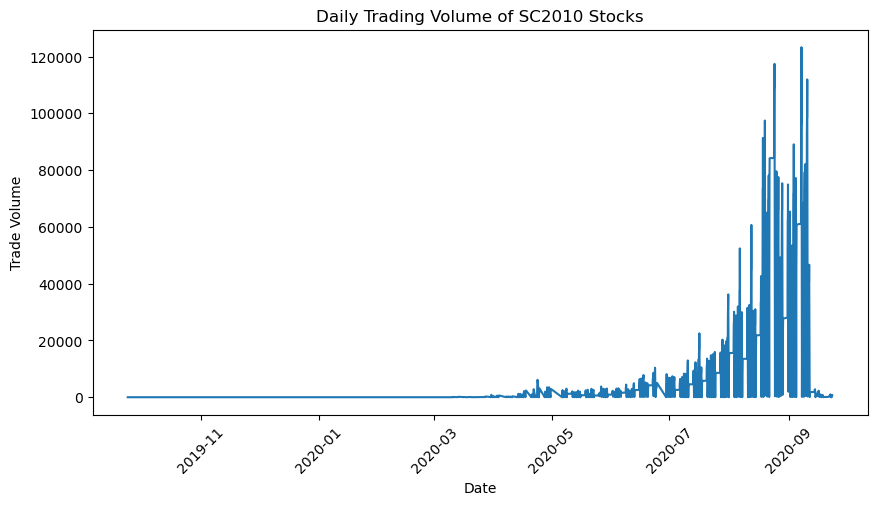

/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_13503/1387701851.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['volume_rolling'] = data_filtered['volume'].rolling(window=window, min_periods=min_periods).mean()
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_13503/1387701851.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['high_volume'] = data_filtered['volume_rolling'] > volume_threshold
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_

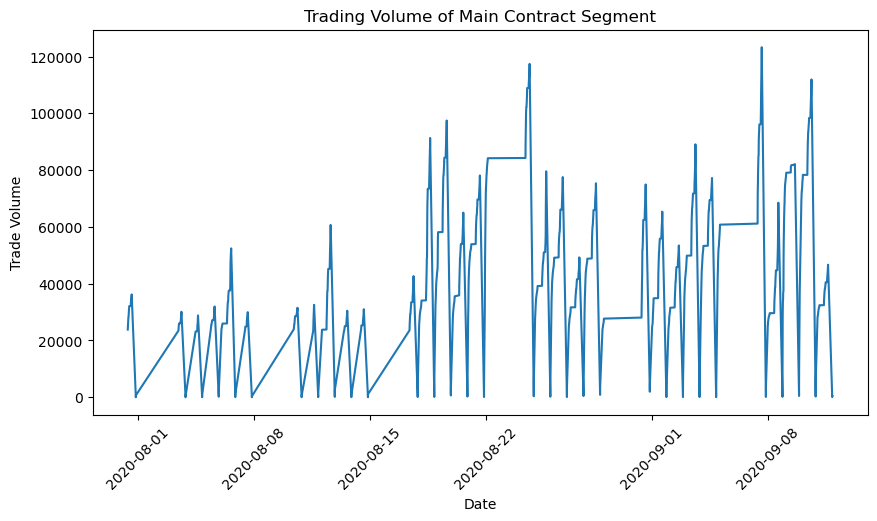

All times are within the specified intervals.


/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_13503/1387701851.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[price_cols] = data[price_cols].apply(lambda row: row.ffill(), axis=1)
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_13503/1387701851.py:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extended_segment['bid_ask_spread'] = extended_segment['ask_price1'] - extended_segment['bid_price1']
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_13503/1387701851.

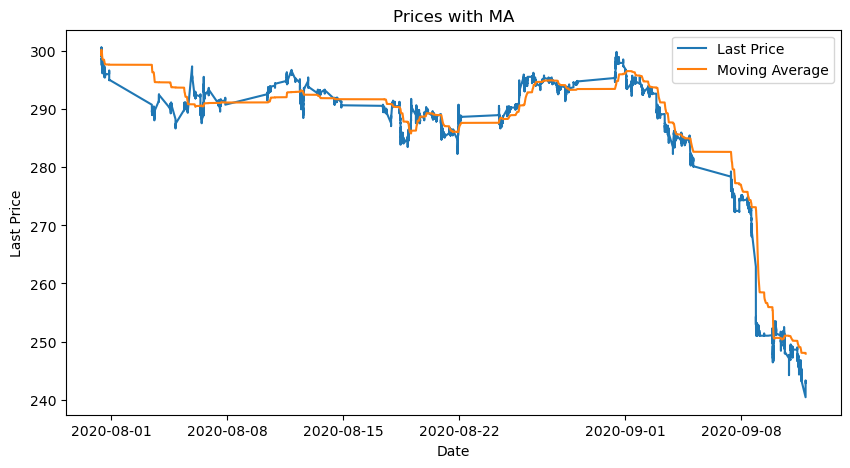

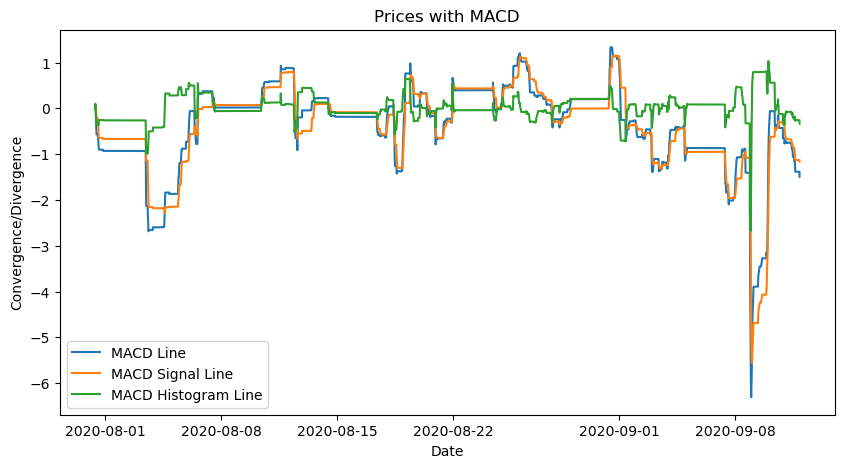

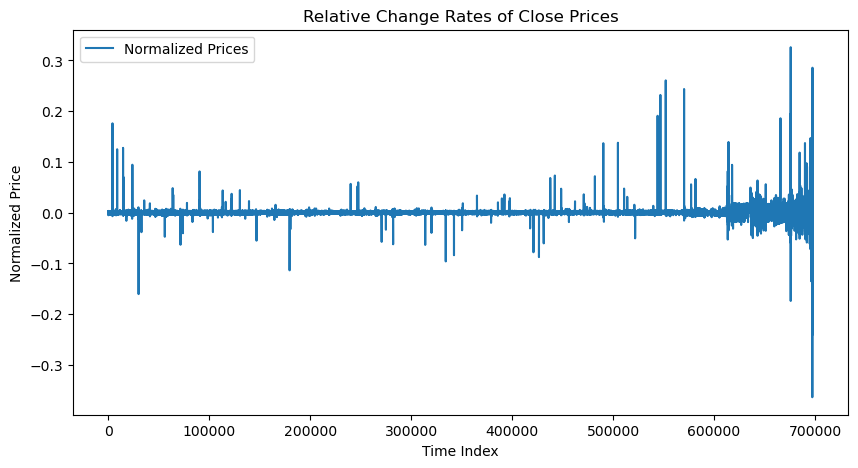

In [ ]:
# Params
dataset_filename = 'INE.sc2010'
intervals = [
    ('21:00:00', '02:30:00'),
    ('09:00:00', '10:15:00'),
    ('10:30:00', '11:30:00'),
    ('13:30:00', '15:00:00')
]
configs_filename = 'configs'

# Load configs file
configs = load_configs(configs_filename)

# Read data
data = pd.read_csv('data/' + dataset_filename + '.csv')
data['datetime'] = pd.to_datetime(data['datetime'])

# Set seed
set_seed(42)

with cProfile.Profile() as pr:
    # Only include data within the specified intervals
    data_filtered = filter_data_by_intervals(data, intervals)
    # pr.print_stats()
    
    # Make sure there are no values outside the given time intervals
    assert_time_intervals(data_filtered, intervals)
    # pr.print_stats()
    
    # Plot trading volume data
    plot_volume(data_filtered, 'Daily Trading Volume of SC2010 Stocks')
    
    # Extract the main contract 
    # data_filtered = data_filtered.copy() # Avoid SettingWithCopyWarning 
    # pr.print_stats()
    data_filtered.iloc[:, 1:] = data_filtered.iloc[:, 1:].astype(np.float32)
    # pr.print_stats()
    extended_segment = extract_main_contract(data_filtered)
    # pr.print_stats()
    
    # Plot main contract segment
    plot_volume(extended_segment, 'Trading Volume of Main Contract Segment')
    # pr.print_stats()
    
    # Set index of the resulting dataframe
    extended_segment.set_index('datetime', inplace=True)
    # pr.print_stats()
    
    # Make sure there are no values outside the given time intervals
    assert_time_intervals(extended_segment, intervals)
    # pr.print_stats()
    
    # Extract needed hyperparams
    input_size = configs['input_size']
    num_steps = configs['num_steps']
    normalize = configs['normalize']
    short_period = configs['short_period']
    long_period = configs['long_period']
    signal_period = configs['signal_period']
    period = configs['period']
    
    # Add factors
    add_factors(extended_segment, short_period, long_period, signal_period, period)
    # pr.print_stats()
    
    # Plot closing prices with factors
    plot_prices_with_ma(extended_segment, 'Prices with MA')
    plot_prices_with_macd(extended_segment, 'Prices with MACD')
    
    # Normalize data
    extended_segment = normalize_data(extended_segment)
    # pr.print_stats()
    assert(extended_segment.isna().sum().sum() == 0)
    
    # Create sequences based on the extended_segment
    extended_segment, train_loader, val_loader, test_loader = create_sequences(extended_segment, num_steps, input_size, normalize)

## Model Definition: LSTM Cell

In [ ]:
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(CustomLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Initialize weights and biases
        self.W_i = nn.Parameter(torch.randn(input_size, hidden_dim))
        self.U_i = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_i = nn.Parameter(torch.zeros(hidden_dim))

        self.W_f = nn.Parameter(torch.randn(input_size, hidden_dim))
        self.U_f = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_f = nn.Parameter(torch.zeros(hidden_dim))
        
        self.W_c = nn.Parameter(torch.randn(input_size, hidden_dim))
        self.U_c = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_c = nn.Parameter(torch.zeros(hidden_dim))
        
        self.W_o = nn.Parameter(torch.randn(input_size, hidden_dim))
        self.U_o = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_o = nn.Parameter(torch.zeros(hidden_dim))
        
        # Layer normalization layers
        self.ln_i = nn.LayerNorm(hidden_dim)
        self.ln_f = nn.LayerNorm(hidden_dim)
        self.ln_c = nn.LayerNorm(hidden_dim)
        self.ln_o = nn.LayerNorm(hidden_dim)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'W_' in name or 'U_' in name:
                nn.init.orthogonal_(param)  # Use orthogonal initialization
            elif 'b_' in name:
                nn.init.constant_(param, 0.0)

            assert(not torch.isnan(param).any())

    def forward(self, x, h, c):
        i_t = torch.sigmoid(self.ln_i(torch.matmul(x, self.W_i) + torch.matmul(h, self.U_i) + self.b_i))
        f_t = torch.sigmoid(self.ln_f(torch.matmul(x, self.W_f) + torch.matmul(h, self.U_f) + self.b_f))
        g_t = torch.tanh(self.ln_c(torch.matmul(x, self.W_c) + torch.matmul(h, self.U_c) + self.b_c))
        o_t = torch.sigmoid(self.ln_o(torch.matmul(x, self.W_o) + torch.matmul(h, self.U_o) + self.b_o))

        c_t = f_t * c + i_t * g_t
        h_t = o_t * torch.tanh(c_t)
        
        assert(not torch.isnan(h_t).any())
        assert(not torch.isnan(c_t).any())
        
        return h_t, c_t

## Model Definition: GRU Cell

In [ ]:
class CustomGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomGRUCell, self).__init__()
        self.hidden_dim = hidden_dim

        # Initialize weights and biases
        self.W_z = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_z = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_z = nn.Parameter(torch.zeros(hidden_dim).float())

        self.W_r = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_r = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_r = nn.Parameter(torch.zeros(hidden_dim).float())
        
        self.W_h = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_h = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_h = nn.Parameter(torch.zeros(hidden_dim).float())
        
        # Layer normalization layers
        self.ln_z = nn.LayerNorm(hidden_dim)
        self.ln_r = nn.LayerNorm(hidden_dim)
        self.ln_h = nn.LayerNorm(hidden_dim)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'W_' in name or 'U_' in name:
                nn.init.xavier_uniform_(param)  # Use orthogonal initialization
            elif 'b_' in name:
                nn.init.constant_(param, 0.0)

            # Check for NaN values
            assert(not torch.isnan(param).any())

    def forward(self, x, h):
        z_t = torch.sigmoid(self.ln_z(torch.mm(x, self.W_z) + torch.mm(h, self.U_z) + self.b_z))
        r_t = torch.sigmoid(self.ln_r(torch.mm(x, self.W_r) + torch.mm(h, self.U_r) + self.b_r))
        h_hat_t = torch.tanh(self.ln_h(torch.mm(x, self.W_h) + torch.mm(r_t * h, self.U_h) + self.b_h))

        h_t = (1 - z_t) * h + z_t * h_hat_t
        
        assert(not torch.isnan(h_t).any())
    
        return h_t

## Model Definition: RNN

In [ ]:
class CustomRNNModel(nn.Module):
    def __init__(self, input_size, num_features, hidden_dim, output_dim, num_layers, dropout_rate, dense_units, cell_type='lstm'):
        super(CustomRNNModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.cell_type = cell_type
        self.input_dim = input_size * num_features

        if cell_type == 'lstm':
            self.layers = nn.ModuleList([CustomLSTMCell(self.input_dim, hidden_dim)])
            self.layers.extend([CustomLSTMCell(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        elif cell_type == 'gru':
            self.layers = nn.ModuleList([CustomGRUCell(self.input_dim, hidden_dim)])
            self.layers.extend([CustomGRUCell(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        else:
            raise ValueError("Unsupported cell type")

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_dim, dense_units)
        self.fc2 = nn.Linear(dense_units, output_dim)

    def forward(self, x):
        batch_size, num_steps, input_size, num_features = x.size()
        x = x.view(batch_size, num_steps, -1)  # Flatten the input dimensions to (batch_size, num_steps, input_size * num_features)

        h_t = [torch.zeros(batch_size, self.hidden_dim, device=x.device) for _ in range(self.num_layers)]
        if self.cell_type == 'lstm':
            c_t = [torch.zeros(batch_size, self.hidden_dim, device=x.device) for _ in range(self.num_layers)]

        for t in range(num_steps):
            x_t = x[:, t, :]
            for layer in range(self.num_layers):
                if self.cell_type == 'lstm':
                    h_t[layer], c_t[layer] = self.layers[layer](x_t, h_t[layer], c_t[layer])
                else:
                    h_t[layer] = self.layers[layer](x_t, h_t[layer])
                x_t = h_t[layer]

        x = self.dropout(x_t)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## RNN Model Training + Evaluation

In [ ]:
# Loss definitions
def quantile_loss(outputs, targets, quantile=0.5):
    errors = targets - outputs
    loss = torch.max((quantile - 1) * errors, quantile * errors)
    return torch.mean(loss)

class HingeLoss(nn.Module):
    def __init__(self):
        super(HingeLoss, self).__init__()

    def forward(self, outputs, targets):
        return torch.mean(torch.clamp(1 - targets * outputs, min=0))

def directional_loss(outputs, targets):
    return torch.mean(torch.abs(torch.sign(outputs) - torch.sign(targets)))

def choose_loss_function(loss, quantile=None):
    if loss == 'huber':
        criterion = nn.SmoothL1Loss()
    elif loss == 'mse':
        criterion = nn.MSELoss()
    elif loss == 'quantile' and quantile is not None:
        criterion = lambda outputs, targets: quantile_loss(outputs, targets, quantile=quantile)
    elif loss == 'hinge':
        criterion = HingeLoss()
    elif loss == 'directional':
        criterion = directional_loss
    else:
        raise ValueError("Unsupported loss function")

    return criterion

In [ ]:
def train_model(model, train_loader, val_loader, criterion, init_epochs, num_epochs, init_learning_rate, learning_rate_decay, device, cell_type, early_stop_patience=None):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    early_stop_counter = 0

    optimizer = optim.Adam(model.parameters(), lr=init_learning_rate)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0)

    for epoch in range(num_epochs):
        model.train()
        current_lr = init_learning_rate * (learning_rate_decay ** max(float(epoch + 1 - init_epochs), 0.0))
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
            
        train_loss = 0.0
        for X_batch, y_batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        scheduler.step()

        if early_stop_patience is not None:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                early_stop_counter = 0
                torch.save(model.state_dict(), f'models/SP500_{cell_type}_model.pth')
            else:
                early_stop_counter += 1
                if early_stop_counter >= early_stop_patience:
                    print("Early stopping triggered")
                    break

    return train_losses, val_losses

# Function to load the model
def load_model(model, cell_type, device):
    model_path = f'models/SP500_{cell_type}_model.pth'
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model

In [ ]:
def train(extended_segment, configs, cell_type):
    # Retrieve CUDA device if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Extract hyperparams
    input_size = configs['input_size']
    num_steps = configs['num_steps']
    num_units = configs[cell_type][cell_type + '_units']
    num_layers = configs[cell_type][cell_type + '_layers']
    dropout_rate = configs[cell_type]['dropout_rate']
    dense_units = configs[cell_type]['dense_units']
    init_learning_rate = configs[cell_type]['init_learning_rate']
    learning_rate_decay = configs[cell_type]['learning_rate_decay']
    init_epochs = configs[cell_type]['init_epochs']
    max_epochs = configs[cell_type]['max_epochs']
    early_stop_patience = configs[cell_type].get('early_stop_patience', None)
    train_needed = configs[cell_type]['pretrain']
    
    num_features = extended_segment.shape[-1]
    
    model = CustomRNNModel(input_size=input_size, num_features=num_features, hidden_dim=num_units, output_dim=input_size, num_layers=num_layers, dropout_rate=dropout_rate, dense_units=dense_units, cell_type=cell_type)
    model.to(device)
    
    if train_needed: 
        start_time = time.time()
        train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, init_epochs, max_epochs, init_learning_rate, learning_rate_decay, device, early_stop_patience, cell_type)
        duration = time.time() - start_time
        torch.save(model.state_dict(), f'models/SP500_{cell_type}_model.pth')
    else:
        # Load the model
        model = load_model(model, cell_type, device)
        duration = 0
        print("Model loaded successfully")
    
    # Plot train and validation loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Loss Curves')
    plt.show()
    
    return model, duration

In [ ]:
# LSTM
criterion = choose_loss_function('huber')
cell_type = 'lstm' 

# Training
model, duration = train(extended_segment, configs, cell_type)
print(f"Training duration: {training_duration} seconds")

In [ ]:
def make_predictions(model, data_loader, device, criterion):
    model.eval()
    predictions = []
    actuals = []
    test_loss = 0
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())
            actuals.append(y_batch.cpu().numpy())
            test_loss += criterion(outputs, y_batch).item()

    test_loss /= len(data_loader)
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    return np.array(predictions).flatten(), np.array(actuals).flatten(), test_loss

def calculate_accuracy(predictions, actuals):
    correct = np.sum(np.sign(predictions) == np.sign(actuals))
    print("correct:", correct)
    total = len(actuals)
    print("total:", total)
    accuracy = correct / total
    return accuracy

 # Plot the predictions against the actual values
def plot_results(input_size, num_steps, actuals, predictions):
    plt.figure(figsize=(10, 5))
    x = np.arange(len(actuals))
    plt.bar(x - 0.2, actuals, label='Actual Prices')
    plt.bar(x + 0.2, predictions, label='Predicted Prices')
    plt.xlabel('Value')
    plt.ylabel('Normalized Price')
    plt.ylim(-0.1, 0.1)
    plt.title(f'Predicted vs Actual Prices for input_size={input_size}, num_steps={num_steps}')
    plt.legend()
    plt.show()

def predict(model, test_loader, input_size, num_steps, criterion):
    # GPU device if possible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Make predictions
    predictions, actuals, test_loss = make_predictions(model, test_loader, device, criterion)

    # Classification accuracy
    classification_accuracy = calculate_accuracy(predictions, actuals)
    
    # Plot results
    plot_results(input_size, num_steps, actuals, predictions)
    
    return test_loss, classification_accuracy

In [ ]:
# Prediction
test_loss, classification_accuracy = predict(model, test_loader, input_size, num_steps, criterion)
print(f"Test loss: {test_loss}")
print(f"Classification accuracy: {classification_accuracy}")

In [ ]:
# GRU
cell_type = 'gru' 

# Training 
model, duration = train(extended_segment, configs, cell_type)
print(f"Training duration: {training_duration} seconds")

In [ ]:
# Prediction
test_loss, classification_accuracy = predict(model, test_loader, input_size, num_steps, criterion)
print(f"Test loss: {test_loss}")
print(f"Classification accuracy: {classification_accuracy}")

In [ ]:
# # Prediction
# predictor = ModelPredictor(trained_model, data_preparation, cell_type, criterion)
# test_loss, classification_accuracy = predictor.predict()
# print(f"Test loss: {test_loss}")
# print(f"Classification accuracy: {classification_accuracy}")

In [ ]:
# cell_type = 'gru'

In [ ]:
# # Training
# trainer = ModelTrainer(data_preparation, cell_type, criterion)
# trained_model, training_duration = trainer.train()
# print(f"Training duration: {training_duration} seconds")

In [ ]:
# # Prediction
# predictor = ModelPredictor(trained_model, data_preparation, cell_type, criterion)
# test_loss, classification_accuracy = predictor.predict()
# print(f"Test loss: {test_loss}")
# print(f"Classification accuracy: {classification_accuracy}")

## Hyperparameter Search

In [ ]:
def grid_search(data_preparation, cell_type, search_space):
    # Define dataframe
    df = pd.DataFrame(columns=['Input Size', 'Number of Steps', 'Test Loss', 'Classification Accuracy', 'Duration'] + list(search_space.keys()))

    # Loop over the hyperparam values
    for param_combination in ParameterGrid(search_space):
        start_time = time.time()
        
        # Modify the hyperparameters
        data_preparation = DataPreparation(dataset_name, 
                                           intervals,
                                           num_steps=param_combination['num_steps'], 
                                           input_size=param_combination['input_size'])
        
        # Modify the model parameters
        if cell_type == 'lstm':
            model_params = {
                'lstm_units': param_combination['lstm_units'],
                'lstm_layers': param_combination['lstm_layers'],
                'dropout_rate': param_combination['dropout_rate'],
                'dense_units': param_combination['dense_units'],
                'init_learning_rate': param_combination['init_learning_rate'],
                'learning_rate_decay': param_combination['learning_rate_decay']
            }
        elif cell_type == 'gru':
            model_params = {
                'gru_units': param_combination['gru_units'],
                'gru_layers': param_combination['gru_layers'],
                'dropout_rate': param_combination['dropout_rate'],
                'dense_units': param_combination['dense_units'],
                'init_learning_rate': param_combination['init_learning_rate'],
                'learning_rate_decay': param_combination['learning_rate_decay']
            }
        
        # Training
        model = CustomRNNModel(data_preparation.input_size, data_preparation.num_features, model_params[cell_type + '_units'], data_preparation.input_size, model_params[cell_type + '_layers'], model_params['dropout_rate'], model_params['dense_units'], cell_type=cell_type)
        trainer = ModelTrainer(data_preparation, cell_type)
        trained_model, training_duration = trainer.train(hyperparam_grid=model_params)

        # Prediction
        predictor = ModelPredictor(trained_model, data_preparation, cell_type)
        test_loss, classification_accuracy = predictor.predict()
        
        # Append the results to the dataframe
        result = param_combination.copy()
        result['Test Loss'] = test_loss
        result['Classification Accuracy'] = classification_accuracy
        result['Duration'] = training_duration
        df = df.append(result, ignore_index=True)
    
    # Save results to CSV
    df.to_csv(f'results/{cell_type}_evaluation_results.csv', index=False)

In [ ]:
def get_best_model(data_preparation, cell_type, search_space, SEARCH_NEEDED=False):
    # Perform grid search if needed (setting SEARCH_NEEDED = TRUE will RUN LONG TIME!!!)
    if SEARCH_NEEDED:
        grid_search(data_preparation, cell_type, search_space)
    
    # Get best model
    df = pd.read_csv(f'results/{cell_type}_evaluation_results.csv')
    idx = np.argmin(df['Test Loss'])
    df_best_model = df.iloc[idx, :]
    return df_best_model

In [ ]:
# Define the hyperparameter search space for LSTM model
lstm_search_space = {
    'input_size': [30],
    'num_steps': [2],
    'lstm_units': [32, 64, 128],
    'lstm_layers': [1, 2, 3, 4, 5, 6, 7, 8],
    'dropout_rate': [0.1, 0.2, 0.3],
    'dense_units': [10, 25, 50],
    'init_learning_rate': [0.0001, 0.001, 0.01],
    'learning_rate_decay': [0.9, 0.99, 1.0]
}

# LSTM hyperparameter search (setting SEARCH_NEEDED = TRUE will RUN LONG TIME!!!)
cell_type = 'lstm'
SEARCH_NEEDED_LSTM = True
df_best_model_lstm = get_best_model(data_preparation, cell_type, lstm_search_space, SEARCH_NEEDED=SEARCH_NEEDED_LSTM)

print("Best LSTM model configuration:")
print(df_best_model_lstm)

In [ ]:
# Modify the input_size and num_steps attributes
data_preparation_lstm = DataPreparation(dataset_name, num_steps=int(df_best_model_lstm['num_steps']), input_size=int(df_best_model_lstm['input_size']))

# Training
trainer_lstm = ModelTrainer(data_preparation_lstm, cell_type, model_params=df_best_model_lstm.to_dict())
trained_model_lstm, training_duration_lstm = trainer_lstm.train()

# Prediction
predictor_lstm = ModelPredictor(trained_model_lstm, data_preparation_lstm, cell_type)
test_loss_lstm, classification_accuracy_lstm = predictor_lstm.predict()

print("Test loss of best LSTM model:", test_loss_lstm)
print("Classification accuracy of best LSTM model:", classification_accuracy_lstm)
print("Duration of best LSTM model:", training_duration_lstm)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


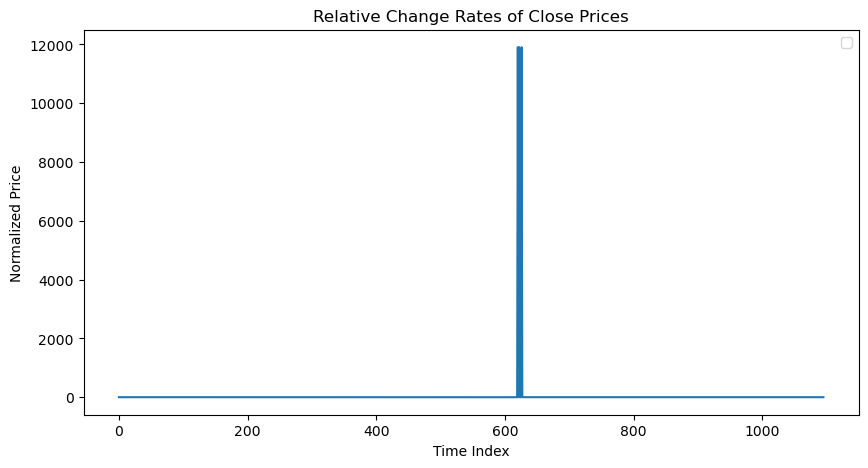

ValueError: not enough values to unpack (expected 4, got 3)

In [93]:
# Define the hyperparameter search space for GRU model
gru_search_space = {
    'input_size': [30],
    'num_steps': [2],
    'gru_units': [32, 64, 128],
    'gru_layers': [3, 4],
    'dropout_rate': [0.1, 0.2, 0.3],
    'dense_units': [10, 25, 50],
    'init_learning_rate': [0.0001, 0.001, 0.01],
    'learning_rate_decay': [0.9, 0.99, 1.0]
}

# GRU hyperparameter search (setting SEARCH_NEEDED = TRUE will RUN LONG TIME!!!)
cell_type = 'gru'
SEARCH_NEEDED_GRU = True
df_best_model_gru = get_best_model(data_preparation, cell_type, gru_search_space, SEARCH_NEEDED=SEARCH_NEEDED_GRU)

print("Best GRU model configuration:")
print(df_best_model_gru)

In [ ]:
# Modify the input_size and num_steps attributes
data_preparation_gru = DataPreparation(dataset_name, num_steps=int(df_best_model_gru['num_steps']), input_size=int(df_best_model_gru['input_size']))

# Training
trainer_gru = ModelTrainer(data_preparation_gru, cell_type, model_params=df_best_model_gru.to_dict())
trained_model_gru, training_duration_gru = trainer_gru.train()

# Prediction
predictor_gru = ModelPredictor(trained_model_gru, data_preparation_gru, cell_type)
test_loss_gru, classification_accuracy_gru = predictor_gru.predict()

print("Test loss of best GRU model:", test_loss_gru)
print("Classification accuracy of best GRU model:", classification_accuracy_gru)
print("Duration of best GRU model:", training_duration_gru)


In [ ]:
# import numpy as np
# from scipy.special import kl_div

# # Sample data for demonstration purposes
# # In practice, you would use actual activation data from the model
# def get_fp32_activation_data():
#     # Replace this with actual data collection
#     return np.array([0.5, 1.0, 2.0, -1.0, -0.5, 3.0, -3.0, 0.1])

# # **1. Calibration: Collect Data and Compute Scale Factor**

# # Collect activation data (replace with actual FP32 data)
# activation_data_fp32 = get_fp32_activation_data()

# # Step 1: Determine the maximum absolute value
# max_abs_value = np.max(np.abs(activation_data_fp32))

# # Step 2: Compute the scale factor for symmetric quantization
# def compute_scale(max_abs_value):
#     return max_abs_value / 127  # 127 because 8-bit quantization uses values from -128 to 127

# scale = compute_scale(max_abs_value)

# # Step 3: Perform preliminary quantization of FP32 data
# def preliminary_quantize(fp32_data, scale):
#     return np.clip(np.round(fp32_data / scale), -128, 127).astype(np.int8)

# activation_data_int8 = preliminary_quantize(activation_data_fp32, scale)

# # Step 4: Compute histograms for FP32 and INT8
# def compute_histograms(fp32_data, int8_data):
#     hist_fp32, _ = np.histogram(fp32_data, bins=2048, range=(-128, 127), density=True)
#     hist_int8, _ = np.histogram(int8_data, bins=2048, range=(-128, 127), density=True)
#     return hist_fp32, hist_int8

# hist_fp32, hist_int8 = compute_histograms(activation_data_fp32, activation_data_int8)

# # Step 5: Compute KL divergence
# def compute_kl_divergence(hist_fp32, hist_int8):
#     # Adding a small constant to avoid log(0)
#     return np.sum(kl_div(hist_fp32 + 1e-8, hist_int8 + 1e-8))

# kl_divergence = compute_kl_divergence(hist_fp32, hist_int8)
# print(f"KL Divergence: {kl_divergence}")

# # **2. Quantization: Convert FP32 to INT8**

# # Final quantization of FP32 data
# def quantize_to_int8(fp32_data, scale):
#     return np.clip(np.round(fp32_data / scale), -128, 127).astype(np.int8)

# activation_data_int8_final = quantize_to_int8(activation_data_fp32, scale)

# # **3. INT32 Computations: Perform Layer Operations**

# # Example INT32 computation function
# def int32_computations(weights, activations, bias):
#     # Perform INT32 matrix multiplication and add bias
#     int32_result = np.dot(weights, activations) + bias
#     return int32_result

# # Sample weights and bias for demonstration
# weights = np.array([[1, -1], [2, 3]])
# bias = np.array([1, -1])

# # Perform INT32 computations
# int32_result = int32_computations(weights, activation_data_int8_final, bias)
# print(f"INT32 Computation Result: {int32_result}")

# # **4. Re-Quantization: Convert INT32 to INT8**

# # Re-quantization process
# def requantize(int32_activations, scale, zero_point, bias):
#     # Add bias and then requantize
#     int32_activations_with_bias = int32_activations + bias
#     return np.clip(np.round(int32_activations_with_bias * scale) + zero_point, -128, 127).astype(np.int8)

# # Assuming zero_point = 0 for symmetric quantization
# zero_point = 0

# # Re-quantize INT32 results to INT8
# activation_data_int8_requantized = requantize(int32_result, scale, zero_point, bias)
# print(f"Re-Quantized INT8 Data: {activation_data_int8_requantized}")

# # **5. De-Quantization: Convert INT8 Back to FP32**

# # De-quantization process
# def dequantize_to_fp32(int8_data, scale, zero_point):
#     return (int8_data - zero_point) * scale

# # Convert INT8 results back to FP32
# fp32_reconstructed_data = dequantize_to_fp32(activation_data_int8_requantized, scale, zero_point)
# print(f"De-Quantized FP32 Data: {fp32_reconstructed_data}")